# Определение стоимости автомобилей

# Оглавление
* [Подготовка к работе](#по_кр)
* [Подготовка данных](#по_да)
    * [Открытие и изучение данных](#от_из)
    * [Предобработка данных](#пр_да)
        * [Удаление дубликатов и лишних столбцов](#уд_ду)
        * [Работа с выбросами ](#ра_вы)
        * [Работа с пропусками](#ра_пр)
        * [Исследование корреляции ](#ис_ко)
        * [Подготовка выборок](#по_вы)
* [Исследование моделей](#ис_мо)
    * [Подготовка `Pipeline`](#по_па)
    * [`LinearRegression`](#ли_ре)
    * [`RandomForestClassifier`](#ра_фо)
    * [`LGBM`](#лг)
    * [`CatBoost`](#кэ)
* [Тестирование лучшей модели](#те_лу)
* [Выводы](#вы)

**Признаки**

* `DateCrawled` — дата скачивания анкеты из базы <br>
* `VehicleType` — тип автомобильного кузова <br>
* `RegistrationYear` — год регистрации автомобиля <br>
* `Gearbox` — тип коробки передач <br>
* `Power` — мощность (л. с.) <br>
* `Model` — модель автомобиля <br>
* `Kilometer` — пробег (км) <br>
* `RegistrationMonth` — месяц регистрации автомобиля <br>
* `FuelType` — тип топлива <br>
* `Brand` — марка автомобиля <br>
* `NotRepaired` — была машина в ремонте или нет <br>
* `DateCreated` — дата создания анкеты <br>
* `NumberOfPictures` — количество фотографий автомобиля <br>
* `PostalCode` — почтовый индекс владельца анкеты (пользователя) <br>
* `LastSeen` — дата последней активности пользователя <br>

**Целевой признак**

* `Price` — цена (евро)

## Подготовка к работе <a class="anchor" id="по_кр"></a>

Импортируем нужные библиотеки, зададим значения параметров и опишем функции.

In [1]:
import pandas as pd
import numpy as np
from IPython.display import Markdown, display

import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats
import seaborn as sns
import phik

from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

import lightgbm as lgbm
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 432907

In [2]:
def data_isna_info(data):
    
    '''
    Функция для вывода статистики по пропущенным значениям в df
    '''
    
    info = (pd.DataFrame({'NA': data.isna().sum(),
                          'NA, %': round((1 - data.count()/len(data))*100, 2)}))

    display(info)

In [3]:
def Price_per(column, threshold, range=False):
    
    '''
    Фунция для вывода графика суммарных продаж для каждого значения в column и
    вывода процента суммарной стоимости автомобилей за порогом threshold
    от общей стоимости
    '''  
    
    data_Price_per = data.groupby(column)['Price'].sum()
    if range:
        data_Price_per = data_Price_per.loc[range]    

    f, ax = plt.subplots(figsize=(7, 4))
    ax.set_yscale("log")
    sns.lineplot(data=data_Price_per, color='blue')
    plt.xlabel(column)
    plt.ylabel('Total Price')
    plt.title(f'Суммарная стоимость автомобилей по {column}')
    plt.grid(True)
    plt.show()

    sum_before_threshold = data_Price_per.loc[:threshold].sum()
    sum_after_threshold = data_Price_per.loc[threshold:].sum()

    display(Markdown(f'Процент суммарной стоимости автомобилей за порогом {column}={threshold} \
    от общей стоимости: \
    **{(max(sum_before_threshold, sum_after_threshold))/(sum_before_threshold + sum_after_threshold):.3f}%**'))

In [4]:
def work_with_outliers(data, column, start=0, end=1, bins=50, discrete=False):

    '''
    Функция для вывода boxplot и histplot для column в data и общей информации о выбросах.
    С помощью start и end можно задать границы данных для тех случаев, когда выбросы имеют
    большое отклонение.
    bins рассчитывается по количеству уникальных значений в column, если их меньше 50.
    Вручную можно выставлять значения от 50.
    discrete позволяет отцентровать столбцы по значенияем на оси x для некоторых графиков.
    '''

    data = data.query(f'{data[column].quantile(start)} <= {column} <= {data[column].quantile(end)}')
    col_uniq_val = data[column].nunique()
    
    if col_uniq_val < 50:
        bins_in = col_uniq_val
    else:
        bins_in = 50
    if bins > 50:
        bins_in = bins
    
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                        gridspec_kw={"height_ratios": (.15, .85)},
                                        figsize=(10,5))

    sns.boxplot(x=data[column], ax=ax_box)
    sns.histplot(data[column], ax=ax_hist, bins=bins_in, kde=True, discrete=discrete)

    ax_box.set(yticks=[])
    ax_box.grid(True, linestyle='--', alpha=0.6)
    ax_hist.set(xlabel='Значение', ylabel='Частота')
    ax_hist.grid(True, linestyle='--', alpha=0.6)
    
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)
    
    plt.suptitle(f'График распределения {column}', y=0.96, fontsize=14)
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.show()

    stats = boxplot_stats(data[column])
    outliers = [value for y in stats for value in y['fliers']]
    q1 = [y['q1'] for y in stats]
    q3 = [y['q3'] for y in stats]

    display(Markdown(f'Нижний квартиль **{int(q1[0])}** и верхний квартиль **{int(q3[0])}**'))
    display(Markdown(f'Граница выбросов: **{sorted(outliers)[0]}**'))
    display(Markdown(f'Количество выбросов **{len(outliers)}**,\
                     что составляет **{len(outliers)/len(data):.3f}%** от всех данных'))

In [5]:
def fill_column_na(dataset, column, fill_column=None,
                   agg_columns=None, agg_func=None, fill_value=None):
    
    '''
    Процедера заполнения пустых значений поля column из набора dataset
    по усредненным значениям соответствующего поля из набора
    с применением групповой орерации agg_func
    со скользящей группировкой по полям agg_columns.
    Если так заполнить не удалось, то пропуски заменяются на fill_value.
    Если fill_value не задано, то на значение, полученное применением agg_func
    к полю column из набора данных.
    '''

    # по умолчанию заменяем из того же поля
    if fill_column is None:
        fill_column = column

    # по умолчанию заменяем наиболее частым значением
    if agg_func is None:
        agg_func = lambda x: x.value_counts().idxmax()

    def get_fill_value(data, key):
        key = tuple(key) if key.shape[0] > 1 else key[0]
        return data.loc[key] if data.index.isin([key]).any() else np.nan

    def apply_agg_func(x):
        try:
            return agg_func(x)
        except:
            return np.nan

    # заполнение по полям группировки
    if agg_columns is not None:
        # для всех срезов группировки от узких к широкому
        for i in range(len(agg_columns), 0, -1):
            # выход, если все пропуски заполнены
            if dataset[column].isna().sum() == 0:
                return

        # список полей для группировки
        group_list = agg_columns[:i]

        # определить справочник для заполнения
        fill_values = dataset.groupby(group_list)[fill_column].agg(apply_agg_func)

        # индексы пропусков
        empty_idx = dataset[dataset[column].isna()].index

        # заполнить пропуски по справочнику
        dataset.loc[empty_idx, column] = dataset.loc[empty_idx][group_list] \
            .apply(lambda x: get_fill_value(fill_values, x), axis=1, raw=False)

    # если константный заполнитель не задан
    if fill_value is None:
        dataset[column] = dataset[column].fillna(dataset[fill_column].agg(agg_func))
    else:
        dataset[column] = dataset[column].fillna(fill_value)

In [6]:
def fill_dataset_na(dataset, fill_na_rules):

    '''
    Функция для передачи в fill_column_na правил заполнения пропусков
    '''
    
    for column, kwargs in fill_na_rules.items():
        print(f'Заполняю пропуски в поле {column}...')
        fill_column_na(dataset, column, **kwargs)

In [7]:
def rmse(target_valid, predicted_valid):
    
    '''
    Метрика rmse
    '''
    
    rmse = mean_squared_error(target_valid, predicted_valid) ** 0.5
    return rmse

In [8]:
def get_variable_name(var_value):

    '''
    Функция получения имени переменной в виде строки
    '''
    
    for var_name, value in globals().items():  # Можно использовать locals() для локальных переменных
        if value is var_value:
            return var_name
    return None

In [9]:
def grid_search_results(grid):

    '''
    Функция вывода информации о результатах обучения grid
    '''
    
    grid_name = get_variable_name(grid)
    display(Markdown(f"Среднее время обучения: **{grid.cv_results_['mean_fit_time'][0].round(2)}** секунды"))
    display(Markdown(f"Время обучения лучшей модели: **{round(grid.refit_time_, 2)}** секунды"))
    display(Markdown(f'RMSE {grid_name} на кросс валидации: **{int(abs(grid.best_score_))}** €'))
    display(Markdown(f'Наилучший набор параметров: {grid.best_params_}'))

In [10]:
def to_category(df):

    '''
    Функция приведения столбцов с типом данных object к типу category
    '''
    
    df_copy = df.copy()
    for col in df_copy.columns:
         if df_copy[col].dtype == 'object':
              df_copy[col] = df_copy[col].astype('category')
    return df_copy

## Подготовка данных <a class="anchor" id="по_да"></a>

### Открытие и изучение данных <a class="anchor" id="от_из"></a>

Откроем `csv` файл, сохраним его в переменную `data` и изучим основные характеристики данных.

In [11]:
data = pd.read_csv('datasets/autos.csv')

In [12]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [14]:
data_isna_info(data)

,NA,"NA, %"
DateCrawled,0,0.00
Price,0,0.00
VehicleType,37490,10.58
RegistrationYear,0,0.00
Gearbox,19833,5.60
Power,0,0.00
Model,19705,5.56
Kilometer,0,0.00
RegistrationMonth,0,0.00
FuelType,32895,9.28


In [15]:
data.duplicated().sum()

4

In [16]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Данные имеют довольно много пропусков, до 20% в некоторых столбцах, присутствуют явные дубликаты. Так же видны выбросы и длинные хвосты в столбцах `RegistrationYear`, `Power` и `Price`. Информация в стобцах `DateCrawled`, `DateCreated`, `NumberOfPictures`, `RegistrationMonth`, `LastSeen` и `PostalCode` скорее всего не влияет на стоимость автомобиля, поэтому эти столбцы стоит отбросить в виду и так большого объёма данных, однако предварительно нужно найти последнюю дату скачивания анкеты из базы в столбце `DateCrawled`, чтобы определить, какие данные из `RegistrationYear` являются актуальными.

### Предобработка данных <a class="anchor" id="пр_да"></a>

#### Удаление дубликатов и лишних столбцов <a class="anchor" id="уд_ду"></a>

Начнём с удаления дубликатов и лишних столбцов, предварительно изучив информацию в `DateCrawled`.

In [17]:
data['DateCrawled'].sort_values().tail()

204218    2016-04-07 14:36:53
53739     2016-04-07 14:36:54
301030    2016-04-07 14:36:55
339649    2016-04-07 14:36:56
90713     2016-04-07 14:36:58
Name: DateCrawled, dtype: object

Последняя дата выгрузки данных - апрель 2016. Все автомобили, с `RegistrationYear` после апреля 2016 года придётся удалить. Пока оставим столбец `RegistrationMonth`, он понадобится для фильтрации.

In [18]:
data = data.drop_duplicates(ignore_index=True)

In [19]:
data = data.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'LastSeen', 'PostalCode'], axis=1)

#### Работа с выбросами <a class="anchor" id="ра_вы"></a>

Посмотрим на распределение значений в столбце `Price`.

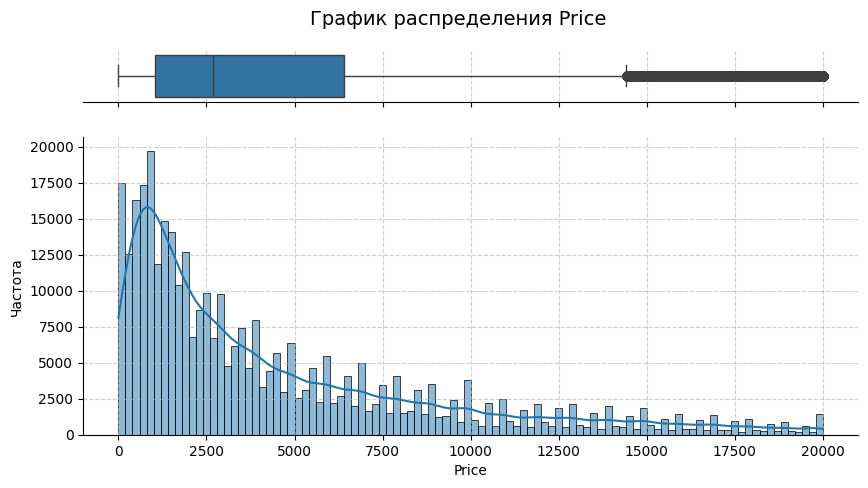

Нижний квартиль **1050** и верхний квартиль **6400**

Граница выбросов: **14430**

Количество выбросов **18979**,                     что составляет **0.054%** от всех данных

In [20]:
column = 'Price'
work_with_outliers(data, column, bins=100)

Распределение выглядит логично, при этом действительно аномальные значения присутствуют только в начале графика, это околонулевые цены, а длинный хвост довольно плавно снижается. Дорогие машины это хорошо, но таких объектов слишком мало, чтобы корректно обучить модель с ними работать. Судя по виду распределения лучше откинуть машины с ценой ниже 50 и выше 15000.

In [21]:
data = data.query('50 <= Price <= 15000')

Посмотрим на распределение значений в столбце `RegistrationYear`.

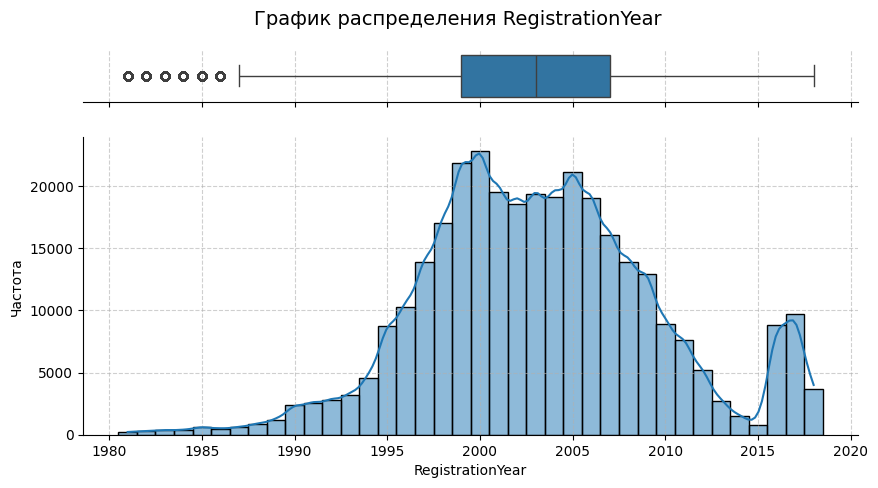

Нижний квартиль **1999** и верхний квартиль **2007**

Граница выбросов: **1981**

Количество выбросов **2397**,                     что составляет **0.007%** от всех данных

In [22]:
column = 'RegistrationYear'
work_with_outliers(data, column, start=.01, end=.99, discrete=True)

Интересный пик в 2016 и 2017 годах после плавного падения с 2005 года. Сложно найти инфомрацию, его объясняющую, возможно это связано с некорректной работой с базой данных, так как в ней не может быть автомобилей, зарегестрированных позднее апреля 2016 года. Отбросим эти данные. Так же нас не интересуют очень старые автомобили и граница в 1980 год вполне устраивает. Да, среди этих автомобилей могут быть коллекционные экземпляры, однако их количество недостаточно для того, чтобы обучить наши модели их корректно определять, а их суммарная стоимость незначительна. Проверим гипотезу про незначительную суммарную стоимость автомобилей по годам регистрации, и если она подтвердится, отбросим автомобили, зарегестрированные ранее 1981 года.

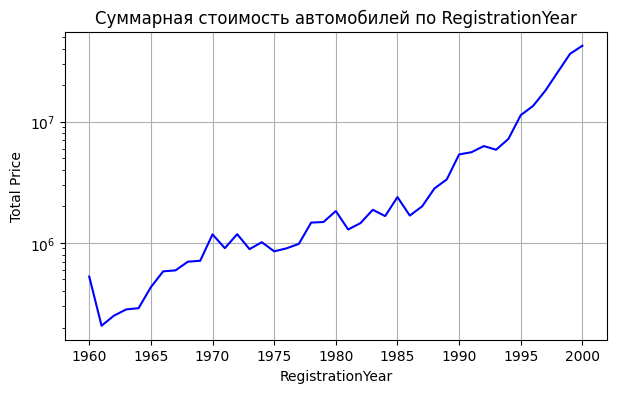

Процент суммарной стоимости автомобилей за порогом RegistrationYear=1980     от общей стоимости:     **0.920%**

In [23]:
Price_per('RegistrationYear', 1980, range(1960, 2001))

Гипотеза подтвердилась, вклад автомобилей до 1980 года в продажи будет незначительным, оставляем промежуток 1980 - апрель 2016.

In [24]:
data = data.query('1980 <= RegistrationYear <= 2016')
data = data.query('not (RegistrationYear == 2016 and RegistrationMonth > 4)')

Посмотрим на распределение значений в столбце `Power`.

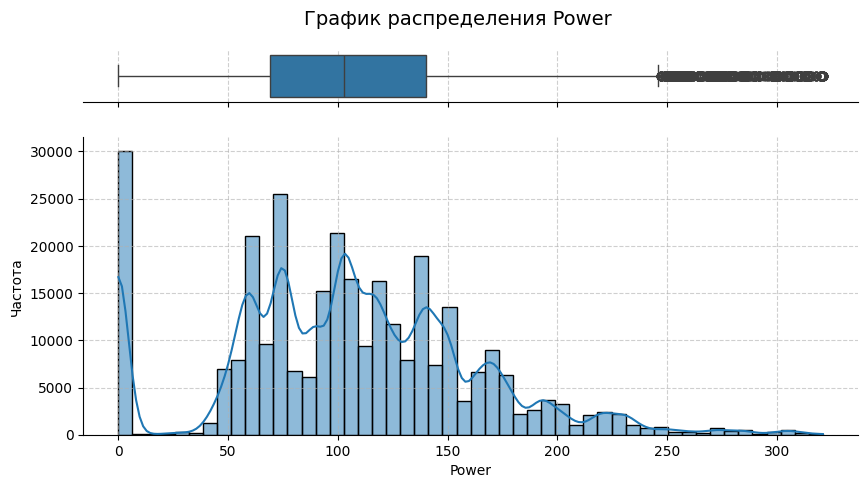

Нижний квартиль **69** и верхний квартиль **140**

Граница выбросов: **247**

Количество выбросов **4211**,                     что составляет **0.014%** от всех данных

In [25]:
column = 'Power'
work_with_outliers(data, column, end=.995)

В данном распределении есть очевидные аномалии, такие как мощность за диапазоном 30-500 л.с. Так же удалим `RegistrationMonth`.

In [26]:
data = data.query('30 <= Power <= 500')
data = data.drop(['RegistrationMonth'], axis=1)

Мы удалили много данных и столбцов. Нужно снова проверить на дубликаты.

In [27]:
print(data.duplicated().sum())
data = data.drop_duplicates(ignore_index=True)

37473


Дубликаты, выбросы и аномалии устранены, займёмся пропусками.

#### Работа с пропусками <a class="anchor" id="ра_пр"></a>

Оценим количество пропусков

In [28]:
data_isna_info(data)

,NA,"NA, %"
Price,0,0.00
VehicleType,7080,2.97
RegistrationYear,0,0.00
Gearbox,4742,1.99
Power,0,0.00
Model,9344,3.92
Kilometer,0,0.00
FuelType,13109,5.50
Brand,0,0.00
Repaired,37002,15.53


Пропусков стало меньше, теперь можно их заполнить. Для этого выполним функцию `fill_column_na`, которая заполняет пропуски медианой или наиболее популярным признаком среди похожих объектов.

In [29]:
fill_na_rules = {

     'Price':
     {
     'agg_columns': ['Brand', 'Model', 'FuelType', 'Gearbox', 'RegistrationYear'],
     'agg_func': 'median'
     },
     
     'Model':
     {
     'agg_columns': ['Brand', 'RegistrationYear'],
     'fill_value': 'no_model'
     },

     'VehicleType':
     {
     'agg_columns': ['Brand', 'Model', 'RegistrationYear'],
     'fill_value': 'other'
     },

     'Gearbox':
     {
     'agg_columns': ['Brand', 'Model', 'RegistrationYear']
     },

     'FuelType':
     {
     'agg_columns': ['Brand', 'Model', 'RegistrationYear']
     },
    
     'Repaired': {
     'agg_columns': ['RegistrationYear']
     },

     'Power': {
     'agg_columns': ['Brand', 'Model', 'FuelType', 'Gearbox', 'RegistrationYear'],
     'agg_func': 'median'
     }
    }

fill_dataset_na(data, fill_na_rules)

Заполняю пропуски в поле Price...
Заполняю пропуски в поле Model...
Заполняю пропуски в поле VehicleType...
Заполняю пропуски в поле Gearbox...
Заполняю пропуски в поле FuelType...
Заполняю пропуски в поле Repaired...
Заполняю пропуски в поле Power...


In [30]:
data_isna_info(data)

,NA,"NA, %"
Price,0,0.0
VehicleType,0,0.0
RegistrationYear,0,0.0
Gearbox,0,0.0
Power,0,0.0
Model,0,0.0
Kilometer,0,0.0
FuelType,0,0.0
Brand,0,0.0
Repaired,0,0.0


Пропуски заполнены, изучим корреляцию между признаками.

#### Исследование корреляции <a class="anchor" id="ис_ко"></a>

interval columns not set, guessing: ['Price', 'RegistrationYear', 'Power', 'Kilometer']


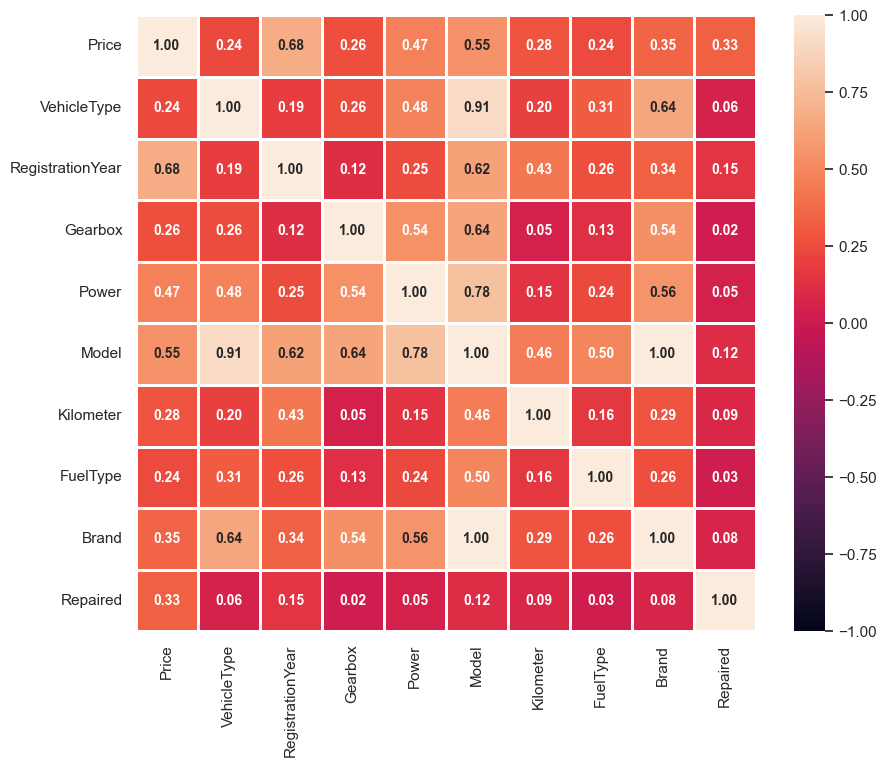

In [31]:
sns.set(rc={'figure.figsize':(10,8)})
sns.heatmap(data.phik_matrix(), vmin=-1, vmax=1, linewidths=1, annot=True, annot_kws={'fontsize':10, 'fontweight':'bold'}, fmt='.2f');

Стобец `Model` коррелирует с многими признаками, его стоит удалить.

In [32]:
data = data.drop(['Model'], axis=1)

#### Подготовка выборок <a class="anchor" id="по_вы"></a>

Осталось разбить датасет на обучающие признаки и целевой признак, затем на тренировочную, валидационную и тестовые выборки в соотношении 3:1:1. Тренировочная выборка будет использоваться для обучения моделей, валидационная для тестирования моделей во время обучения. Тестовую выборку отложем до самого последнего момента, когда лучшая модель уже будет выбрана. Такой сценарий наиболее приближён к реальному, когда тестовая выборка зачастую недоступна при разбработке моделей и истинную метрику можно получить уже после того, как модель будет выбрана и обучена. 

In [33]:
X = data.drop(['Price'], axis=1)
y = data['Price']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

## Исследование моделей <a class="anchor" id="ис_мо"></a>

### Подготовка `Pipeline` <a class="anchor" id="по_па"></a>

Выделим категориальные, бинарные и числовые признаки.

In [35]:
obj_columns = X.select_dtypes('object').columns.tolist()
obj_columns.remove('Repaired')

cat_columns = obj_columns
bin_columns = ['Repaired']
num_columns = X.select_dtypes('number').columns.tolist()

print("Категориальные признаки:", cat_columns)
print("Бинарные признаки:", bin_columns)
print("Числовые признаки:", num_columns)

Категориальные признаки: ['VehicleType', 'Gearbox', 'FuelType', 'Brand']
Бинарные признаки: ['Repaired']
Числовые признаки: ['RegistrationYear', 'Power', 'Kilometer']


Для обучения линейной регрессии и случайного леса к данным необходимо применить `OneHotEncoder` и `OrdinalEncoder` соответственно, а так же `StandardScaler`. Однако необходимо соблюдать правильный порядок операций, чтобы избежать утечки информации в тестовую выборку при обучении трансформера и преобразовании данных. Предобрабатывать данные вручную слишком затратно по времени и ресурсам. Для таких операций существует `Pipeline`. Создадим отдельный пайплайн для категориальных признаков, в который включим оба энкодера. Затем создадим объект `ColumnTransformer`, в котором объединим обработку всех трёх типов данных.

In [36]:
cat_pipline = Pipeline([
                        ('OrdinalEncoder', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value=-1)),
                        ('OneHotEncoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
                        ])

columns_pipeline=ColumnTransformer([
                                    ('category_encoder', cat_pipline, cat_columns),
                                    ('num_scaler', StandardScaler(), num_columns),                                    
                                    ('binary_encoder', OneHotEncoder(drop='first'), bin_columns)
                                    ], remainder='passthrough')
columns_pipeline

ColumnTransformer(remainder='passthrough',
                  transformers=[('category_encoder',
                                 Pipeline(steps=[('OrdinalEncoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1)),
                                                 ('OneHotEncoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['VehicleType', 'Gearbox', 'FuelType',
                                  'Brand']),
                                ('num_scaler', StandardScaler(),
                                 ['RegistrationYear', 'Power', 'Kilometer']),
                                ('binary_encoder', OneHotEncoder(drop='first'),
                                 ['Repaired'])])

Добавим в пайплайн объект `reg` со значением по умолчанию `LinearRegression()`, в который будет передавать модели.

In [37]:
pipeline = Pipeline([
                    ('preprocessing', columns_pipeline),
                    ('reg', LinearRegression())
                    ])
pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('category_encoder',
                                                  Pipeline(steps=[('OrdinalEncoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1)),
                                                                  ('OneHotEncoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['VehicleType', 'Gearbox',
                                                   'FuelType', 'Brand']),
                                                 ('num_scaler',
                                                  StandardScaler(),
                                                  ['RegistrationYear', 'Power',
                                                   'Kilometer']),
                                                 ('binary_encoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['Repaired'])])),
                ('reg', LinearRegression())])

Последний шаг - создание `my_scorer` с функцией вычисления метрики `RMSE` и параметром `greater_is_better=False` для передачи его в `GridSearchCV`.

In [38]:
my_scorer = make_scorer(rmse, greater_is_better=False)

### `LinearRegression` <a class="anchor" id="ли_ре"></a>

Начнём с `LinearRegression`. Установим для `OrdinalEncoder` значение `None`, чтобы его "выключить", затем передадим `pipeline` и набор параметров `params_LR` в `GridSearchCV`, указав в качестве метрики заранее созданный `my_scorer`.

In [39]:
params_LR = [{
              'reg': [LinearRegression()],
              'preprocessing__category_encoder__OrdinalEncoder': [None]
            }]

grid_LR = GridSearchCV(pipeline,
                       params_LR,
                       cv=3,
                       verbose=1,                   
                       scoring=my_scorer) 

In [40]:
grid_LR.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('category_encoder',
                                                                         Pipeline(steps=[('OrdinalEncoder',
                                                                                          OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                         unknown_value=-1)),
                                                                                         ('OneHotEncoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['VehicleType',
                                                                          'Gearbox',
                                                                          'FuelT...
                                                                        ('num_scaler',
                                                                         StandardScaler(),
                                                                         ['RegistrationYear',
                                                                          'Power',
                                                                          'Kilometer']),
                                                                        ('binary_encoder',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['Repaired'])])),
                                       ('reg', LinearRegression())]),
             param_grid=[{'preprocessing__category_encoder__OrdinalEncoder': [None],
                          'reg': [LinearRegression()]}],
             scoring=make_scorer(rmse, greater_is_better=False, response_method='predict'),
             verbose=1)

In [41]:
grid_search_results(grid_LR)

Среднее время обучения: **0.65** секунды

Время обучения лучшей модели: **1.0** секунды

RMSE _ на кросс валидации: **2200** €

Наилучший набор параметров: {'preprocessing__category_encoder__OrdinalEncoder': None, 'reg': LinearRegression()}

Получены результаты для линейной регрессии. Приступим к случайному лесу.

### `RandomForestRegressor` <a class="anchor" id="ра_фо"></a>

Для `RandomForestRegressor` "отключим" `OneHotEncoder`, при этом оставим `StandardScaler`, который не является обязательным для "деревянных" моделей.

In [42]:
%%time

params_RFC = [{
               'reg': [RandomForestRegressor(random_state=RANDOM_STATE)],
               'preprocessing__category_encoder__OneHotEncoder': [None],
               'reg__max_depth':[3], 
               'reg__n_estimators':[10]
              }]

params_RFC = [{
               'reg': [RandomForestRegressor(random_state=RANDOM_STATE)],
                'preprocessing__category_encoder__OneHotEncoder': [None],
                'reg__max_depth':[4, 10, None], 
                'reg__n_estimators':[50, 100, 200],
                'reg__min_samples_leaf':[1, 2, 3],
              }]

grid_RFC = GridSearchCV(pipeline,
                        params_RFC,
                        cv=3,
                        scoring=my_scorer) 

grid_RFC.fit(X_train, y_train);

CPU times: total: 19min 19s
Wall time: 19min 20s


In [43]:
grid_search_results(grid_RFC)

Среднее время обучения: **2.67** секунды

Время обучения лучшей модели: **50.45** секунды

RMSE grid_RFC на кросс валидации: **1434** €

Наилучший набор параметров: {'preprocessing__category_encoder__OneHotEncoder': None, 'reg': RandomForestRegressor(random_state=432907), 'reg__max_depth': None, 'reg__min_samples_leaf': 3, 'reg__n_estimators': 200}

Случайный лес справился с задачей значительно лучше, при этом среднее время обучения модели увеличилось в 4 раза, но это все ещё приемлемые значения, однако стоит обратить внимание на довольно долгое обучение лучшей модели. Рассмотрим `LGBM`.

### `LGBM` <a class="anchor" id="лг"></a>

Бустинговые модели, такие как `LGBM` и `CatBoost` не требуют предобработки признаков, только выделение категориальных признаков. Для `LGBM` это преобразоdание столбцов `object` к типу `category`. 

In [44]:
X_LGBM = to_category(X)

In [45]:
X_LGBM_train, X_LGBM_test = train_test_split(X_LGBM, test_size=0.2, random_state=RANDOM_STATE)

In [46]:
%%time

model_LGBM = LGBMRegressor(random_state=RANDOM_STATE,
                           verbose=-100,
                           n_jobs=-1)

params_LGBM = [{
                'num_leaves': [60, 90, 150],
                'max_depth': [-1, 10, 30],
                'learning_rate': [0.01, 0.03, 0.1],
                'boosting_type' : ['gbdt', 'dart']
              }]

grid_LGBM = GridSearchCV(model_LGBM,
                         params_LGBM,
                         cv=3,
                         scoring=my_scorer) 

grid_LGBM.fit(X_LGBM_train, y_train);

CPU times: total: 29min 34s
Wall time: 2min 37s


In [47]:
grid_search_results(grid_LGBM)

Среднее время обучения: **0.4** секунды

Время обучения лучшей модели: **0.72** секунды

RMSE grid_LGBM на кросс валидации: **1386** €

Наилучший набор параметров: {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': -1, 'num_leaves': 150}

`LGBM` во всём обошёл предыдущие модели, однако ожидалось, что разница по качеству будет заметнее. Остался `CatBoost`.

### `CatBoost` <a class="anchor" id="кэ"></a>

Для корректной работы `CatBoost` нужно выделить категориальные признаки в `cat_features`. Так же стоит отметить, что `CatBoost` имеет свой `gridsearch`, однако в данном исследовании он рассматриваться не будет в связи с отсутствием поддержки некоторых фичей.

In [48]:
%%time

model_CB = CatBoostRegressor(random_state=RANDOM_STATE,
                             cat_features=X.select_dtypes('object').columns.tolist(),
                             task_type="GPU",
                             verbose=0)

params_CB = [{
              'learning_rate':[0.01, 0.03, 0.1], 
              'depth':[6, 9, 12],
              'l2_leaf_reg':[1, 5, 10],
             }]

grid_CB = GridSearchCV(model_CB,
                         params_CB,
                         cv=3,
                         scoring=my_scorer) 

grid_CB.fit(X_train, y_train);

CPU times: total: 1h 18min 42s
Wall time: 55min 6s


In [49]:
grid_search_results(grid_CB)

Среднее время обучения: **17.43** секунды

Время обучения лучшей модели: **76.58** секунды

RMSE grid_CB на кросс валидации: **1382** €

Наилучший набор параметров: {'depth': 12, 'l2_leaf_reg': 10, 'learning_rate': 0.1}

`CatBoost` показал наилучшее значение метрики, однако время его обучения значительно превышает время обучения `LGBM`. Не думаю, что заказчику будет удобно будет работать с такими долгими расчётами. Поэтому в качестве лучшей модели стоит выбрать `LGBM` с набором гиперпараметров `boosting_type: gbdt`, `learning_rate: 0.1`, `max_depth: -1` и `num_leaves: 150`. 

## Тестирование лучшей модели <a class="anchor" id="те_лу"></a>

Можно в `best_model` передать  `grid_LGBM.best_estimator_`, но для наглядности создадим новую модель и перепишем в неё гиперпараметры

In [50]:
best_model = LGBMRegressor(random_state=RANDOM_STATE,
                           boosting_type='gbdt',
                           learning_rate=0.1,
                           max_depth=-1,
                           num_leaves=150,
                           verbose=-100,
                           n_jobs=-1)

best_model.fit(X_LGBM_train, y_train)

display(Markdown(f'RMSE лучшей модели: **{int(rmse(best_model.predict(X_LGBM_test), y_test))}**'))

RMSE лучшей модели: **1368**

Отличный результат. Так же библиотека `lightgbm` имеет встроенный метод `plot_importance`, который позволяет визуализировать важность признаков.

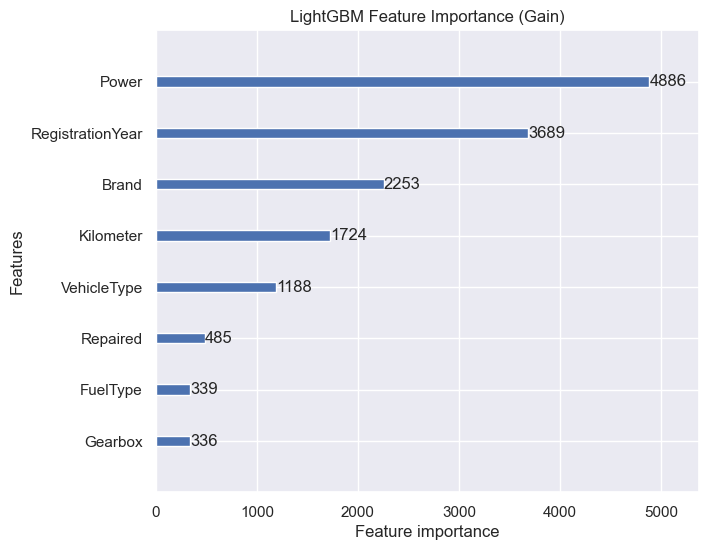

In [51]:
lgbm.plot_importance(best_model, importance_type="split", figsize=(7,6), title="LightGBM Feature Importance (Gain)")
plt.show()

Не самый красивый график получается, поправим.

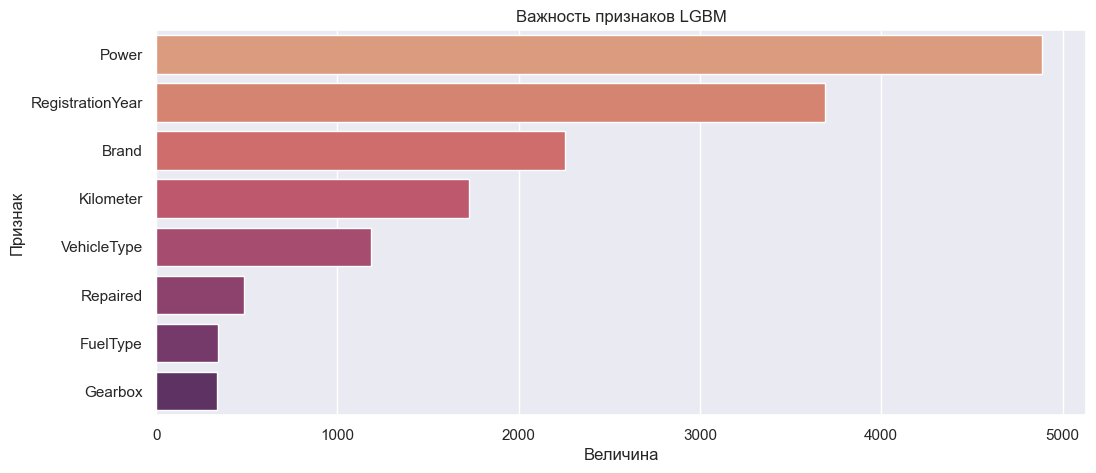

In [52]:
feature_imp = pd.DataFrame(sorted(zip(best_model.feature_importances_, X.columns)), columns=['Величина', 'Признак'])

plt.figure(figsize=(12, 5))
colors = sns.color_palette("flare", len(feature_imp))

sns.barplot(x="Величина", y="Признак", data=feature_imp.sort_values(by="Величина", ascending=False), palette=colors)
plt.title('Важность признаков LGBM')
plt.show()

Так лучше. Из графика видно, что самый важный признак - мощность машины. Так же очень важен год регистрации или другими словами, насколько стара машина. За ним идёт брэнд и километраж.

## Вывод <a class="anchor" id="вы"></a>

Целью данного проекта являлось построение модели для предсказания стоимости автомобилей по их характеристикам. Предоставленные для этого данные содержали пропуски, выбросы и коллинеарные признаки, которые были устранены. Для решения задачи выбраны модели `LinearRegression`, `RandomForestRegressor`, `LGBM` и `CatBoost`. Наилучшие результаты показал `LGBM` с гиперпараметрами `boosting_type: gbdt`, `learning_rate: 0.1`, `max_depth: -1` и `num_leaves: 150`, его `RMSE` лишь незначительно хуже, чем у `CatBoost` и составляет **1386** € при валидации и **1368** € на тестовой выборке, но при этом время работы разительно лучше, даже при таком большом наборе тренировочных данных (203074, 9), обучение модели происходит примерно за секунду. Самый важный признак - *мощность автомобиля*.